In [12]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer, IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 1. Load and preprocess data

In [1]:
!hadoop fs -du -s -h 'gs://msca-bdp-students-bucket/shared_data/jejiang/temp4/'

493.3 M  493.3 M  gs://msca-bdp-students-bucket/shared_data/jejiang/temp4


In [2]:
# Declare data path
path = 'gs://msca-bdp-students-bucket/shared_data/jejiang/temp4/'
file = '*.json'

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [4]:
# Load data
raw_data = spark.read.json(path + file)

In [5]:
raw_data.limit(5)

created_at,favorite_count,id,lang,reply_count,retweet_count,rs_retweet_count,text,timestamp_ms,user_created_at,user_favourites_count,user_followers_count,user_friends_count,user_id,user_location,user_name,user_screen_name,user_verified
Tue Jan 28 21:15:...,0,1222267030163738624,en,0,0,3,RT @FluidImaging:...,1580246143271,Sun Jun 24 20:26:...,3623,3328,1116,617523894,U.S.A.,NMEA,NatlMarineEd,false
Tue Jan 28 21:17:...,0,1222267490492764161,en,0,0,null,Brookline Apartme...,1580246253022,Wed Jun 17 18:10:...,1,120,207,48053733,"Brookline, MA",Brookline Apartments,BrooklinePads,false
Tue Jan 28 21:18:...,0,1222267690896760833,en,0,0,null,All female coachi...,1580246300802,Sat Jun 18 02:30:...,397,37436,955,319412729,United States,Kristine Lilly,KristineLilly,false
Tue Jan 28 21:24:...,0,1222269174585659393,en,0,0,null,Ishuan Li and Hon...,1580246654541,Tue Oct 04 17:53:...,7,4,7,783364531493801984,null,ODE (Official),ODEMedia,false
Tue Jan 28 21:24:...,0,1222269235029794816,en,0,0,1,RT @KristineLilly...,1580246668952,Thu Sep 13 12:00:...,3323,16,305,821381772,"Raleigh, NC",Emily,eadaly11,false


In [6]:
# Print out schema
raw_data.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- id: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- reply_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- rs_retweet_count: long (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp_ms: string (nullable = true)
 |-- user_created_at: string (nullable = true)
 |-- user_favourites_count: long (nullable = true)
 |-- user_followers_count: long (nullable = true)
 |-- user_friends_count: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_verified: boolean (nullable = true)



In [7]:
# Check how many rows and columns
print((raw_data.count(), len(raw_data.columns)))

(877155, 18)


In [11]:
# Check null values
raw_data.agg(*[count(when(isnull(c), c)).alias(c) for c in raw_data.columns])

created_at,favorite_count,id,lang,reply_count,retweet_count,rs_retweet_count,text,timestamp_ms,user_created_at,user_favourites_count,user_followers_count,user_friends_count,user_id,user_location,user_name,user_screen_name,user_verified
0,0,0,0,35002,0,264940,0,0,0,0,0,0,0,255787,0,0,0


In [8]:
# Fill relevant columns with null values
raw_data = raw_data.na.fill({'rs_retweet_count': 0, 'reply_count': 0, 'user_location': 'no info'})

In [13]:
# Check null values after fill null values
raw_data.agg(*[count(when(isnull(c), c)).alias(c) for c in raw_data.columns])

created_at,favorite_count,id,lang,reply_count,retweet_count,rs_retweet_count,text,timestamp_ms,user_created_at,user_favourites_count,user_followers_count,user_friends_count,user_id,user_location,user_name,user_screen_name,user_verified
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# Drop na values
data = raw_data.dropna()

In [10]:
print((data.count(), len(data.columns)))

(877155, 18)


In [13]:
# Change some of the string columns to integer or timestamp
data = data.\
withColumn("favorite_count", data["favorite_count"].cast(IntegerType())).\
withColumn("rs_retweet_count", data["rs_retweet_count"].cast(IntegerType())).\
withColumn("reply_count", data["reply_count"].cast(IntegerType())).\
withColumn("retweet_count", data["retweet_count"].cast(IntegerType())).\
withColumn("user_followers_count", data["user_followers_count"].cast(IntegerType())).\
withColumn("user_friends_count", data["user_friends_count"].cast(IntegerType())).\
withColumn("user_favourites_count", data["user_favourites_count"].cast(IntegerType()))

In [14]:
data.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- favorite_count: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- reply_count: integer (nullable = false)
 |-- retweet_count: integer (nullable = true)
 |-- rs_retweet_count: integer (nullable = false)
 |-- text: string (nullable = true)
 |-- timestamp_ms: string (nullable = true)
 |-- user_created_at: string (nullable = true)
 |-- user_favourites_count: integer (nullable = true)
 |-- user_followers_count: integer (nullable = true)
 |-- user_friends_count: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_location: string (nullable = false)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_verified: boolean (nullable = true)



In [15]:
data.limit(5)

created_at,favorite_count,id,lang,reply_count,retweet_count,rs_retweet_count,text,timestamp_ms,user_created_at,user_favourites_count,user_followers_count,user_friends_count,user_id,user_location,user_name,user_screen_name,user_verified
Thu Jul 16 03:27:...,0,1283604036659355649,en,0,0,2,RT @Girl99Gone: #...,1594870025206,Mon Jun 15 13:43:...,1880,332,436,1272525140199342080,no info,Amy4PDJT,amy31223455,false
Thu Jul 16 03:27:...,0,1283604057643339776,en,0,0,14,RT @ThinkerAmeric...,1594870030209,Thu Dec 19 20:12:...,26141,1889,2250,1207755448725585920,Phoenix,Trump Rocks 2020?...,GingerUSA20,false
Thu Jul 16 03:28:...,0,1283604280520224770,en,0,0,15,RT @ThinkerAmeric...,1594870083347,Sun Jun 14 04:29:...,478,134,243,1272023230895669248,USA,If you can riot y...,destroydamatrix,false
Thu Jul 16 03:59:...,0,1283612153325420544,en,0,0,0,this guy was give...,1594871960370,Fri Sep 24 03:31:...,1505,40,77,194439089,Vladivostok,🇳amed,postposadist,false
Thu Jul 16 04:05:...,0,1283613600209416194,en,0,0,5,RT @numarchmadnes...,1594872305334,Tue Mar 31 06:53:...,661,61,72,1244880420698816512,no info,Eleanor Python,EleanorPython,false


In [16]:
# Generate pyspark dataframe for each university
uchicago = data.where("lower(text) like '%university of chicago%'")
northwestern = data.where("lower(text) like '%northwestern university%'")
boston = data.where("lower(text) like '%boston university%'")
northeastern = data.where("lower(text) like '%northeastern university%'")

## 2. Analyze tweets

### 1). Find the most influential Twitters for each university

#### By message volume

In [21]:
uchicago.groupBy("user_screen_name").agg(count("*").alias("number_of_tweets")).orderBy("number_of_tweets", ascending = False).limit(5)

user_screen_name,number_of_tweets
chiftf_uchicago,586
haileysecretary,367
sofiaorden,311
n8taki,284
wendchain,283


In [22]:
northwestern.groupBy("user_screen_name").agg(count("*").alias("number_of_tweets")).orderBy("number_of_tweets", ascending = False).limit(5)

user_screen_name,number_of_tweets
money_personal,407
Derek_Morgan_,336
GamerGeekNews,279
NUCatFan23,245
meconway703,176


In [23]:
boston.groupBy("user_screen_name").agg(count("*").alias("number_of_tweets")).orderBy("number_of_tweets", ascending = False).limit(5)

user_screen_name,number_of_tweets
BrooklinePads,4551
allstonpads,3901
missionhillpads,3872
brightonpads,3451
chestnuthillpad,3405


In [24]:
northeastern.groupBy("user_screen_name").agg(count("*").alias("number_of_tweets")).orderBy("number_of_tweets", ascending = False).limit(5)

user_screen_name,number_of_tweets
NUWxSTEM,11489
DisabledJobs,1369
irfeed3,232
NikBearBrown,97
xuexiangzheng,89


Top twitterer for each university if evaluated by the number of tweets:
<br>Uchicago: chiftf_uchicago
<br>Northwestern: money_personal
<br>Boston: BrooklinePads
<br>Northeastern: NUWxSTEM

#### By message retweet

In [25]:
uchicago.groupBy("user_screen_name").agg(sum("rs_retweet_count").alias("number_of_retweets")).orderBy("number_of_retweets", ascending = False).limit(5)

user_screen_name,number_of_retweets
Goal58014091,108780
rajbhar9717,60334
asli_chaiwala,42966
RAMANTH06648831,41419
RewantPrajapat1,35244


In [26]:
northwestern.groupBy("user_screen_name").agg(sum("rs_retweet_count").alias("number_of_retweets")).orderBy("number_of_retweets", ascending = False).limit(5)

user_screen_name,number_of_retweets
davidgura,12504
HiJCP,11346
HollyJo21438977,11240
clbrownjr,10038
ReadySetRock75,9878


In [27]:
boston.groupBy("user_screen_name").agg(sum("rs_retweet_count").alias("number_of_retweets")).orderBy("number_of_retweets", ascending = False).limit(5)

user_screen_name,number_of_retweets
MarkoSilberhand,100629
GoldfingerMarko,60912
diaryofugo,60410
cbrad1713,60260
bakedvibez,56420


In [28]:
northeastern.groupBy("user_screen_name").agg(sum("rs_retweet_count").alias("number_of_retweets")).orderBy("number_of_retweets", ascending = False).limit(5)

user_screen_name,number_of_retweets
DreeProvince,35189
iHATErapists69,23402
steven_thegypsy,22970
2desi2function,22213
DezisGOAT,22004


Top twitterer for each university if evaluated by retweets count:
<br>Uchicago: Goal58014091
<br>Northwestern: davidgura
<br>Harvard: MarkoSilberhand
<br>Northeastern: DreeProvince

#### How much are they tweeting about the universities vs. other topics

In [94]:
# Load json files that includes the tweets of above 8 influential twitterers
twer_path = 'gs://msca-bdp-students-bucket/shared_data/jejiang/temp5/'
twer_file = '*.json'

In [95]:
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [96]:
top_tt = spark.read.json(twer_path + twer_file)

In [97]:
top_tt.limit(5)

created_at,favorite_count,id,lang,reply_count,retweet_count,rs_retweet_count,text,timestamp_ms,user_created_at,user_favourites_count,user_followers_count,user_friends_count,user_id,user_location,user_name,user_screen_name,user_verified
Wed Nov 13 14:44:...,0,1194626981104472064,en,0,0,null,Launch Strategy: ...,1573656242048,Sun Nov 25 09:28:...,56,572,291,1066624777807429632,null,Personal Growth a...,money_personal,false
Thu Nov 14 04:33:...,0,1194835602727821315,en,0,0,null,Effective Communi...,1573705981319,Sun Nov 25 09:28:...,56,577,291,1066624777807429632,null,Personal Growth a...,money_personal,false
Sun Nov 17 17:22:...,0,1196116291506978816,en,0,0,null,The American Sout...,1574011321318,Sun Nov 25 09:28:...,56,593,294,1066624777807429632,null,Personal Growth a...,money_personal,false
Sun Nov 17 18:33:...,0,1196134161683083264,en,0,0,null,Internet of Thing...,1574015581900,Sun Nov 25 09:28:...,56,594,294,1066624777807429632,null,Personal Growth a...,money_personal,false
Tue Nov 19 18:22:...,0,1196856170834624512,en,0,0,null,Health Care Deliv...,1574187722296,Sun Nov 25 09:28:...,56,601,294,1066624777807429632,null,Personal Growth a...,money_personal,false


In [98]:
# University of Chicago - Twitterer tweets most about the university
uch1 = top_tt.where("lower(user_screen_name) like '%chiftf_uchicago%'")
uch_uni1 = uch1.where("lower(text) like '%university of chicago%'")

uch_cnt1 = uch1.count()
uch_uni_cnt1 = uch_uni1.count()

uch_oth_cnt1 = uch_cnt1 - uch_uni_cnt1
uch_uni1_ratio = uch_uni_cnt1/uch_cnt1*100
uch_oth1_ratio = uch_oth_cnt1/uch_cnt1*100 

print(uch_uni1_ratio, "% of the user chiftf_uchicago's tweets are about the university")
print(uch_oth1_ratio, "% of the user chiftf_uchicago's tweets are about other stuff")

67.04805491990847 % of the user chiftf_uchicago's tweets are about the university
32.951945080091534 % of the user chiftf_uchicago's tweets are about other stuff


In [99]:
# University of Chicago - Twitterer with most retweets count Goal58014091
uch2 = top_tt.where("lower(user_screen_name) like '%goal58014091%'")
uch_uni2 = uch2.where("lower(text) like '%university of chicago%'")

uch_cnt2 = uch2.count()
uch_uni_cnt2 = uch_uni2.count()

uch_oth_cnt2 = uch_cnt2 - uch_uni_cnt2
uch_uni2_ratio = uch_uni_cnt2/uch_cnt2*100
uch_oth2_ratio = uch_oth_cnt2/uch_cnt2*100 

print(uch_uni2_ratio, "% of the user Goal58014091's tweets are about the university")
print(uch_oth2_ratio, "% of the user Goal58014091's tweets are about other stuff")

100.0 % of the user Goal58014091's tweets are about the university
0.0 % of the user Goal58014091's tweets are about other stuff


In [100]:
# Northwestern University - Twitterer tweets most about the university
nw1 = top_tt.where("lower(user_screen_name) like '%money_personal%'")
nw_uni1 = nw1.where("lower(text) like '%northwestern university%'")

nw_cnt1 = nw1.count()
nw_uni_cnt1 = nw_uni1.count()

nw_oth_cnt1 = nw_cnt1 - nw_uni_cnt1
nw_uni1_ratio = nw_uni_cnt1/nw_cnt1*100
nw_oth1_ratio = nw_oth_cnt1/nw_cnt1*100 

print(nw_uni1_ratio, "% of the user money_personal's tweets are about the university")
print(nw_oth1_ratio, "% of the user money_personal's tweets are about other stuff")

1.1659141567125795 % of the user money_personal's tweets are about the university
98.83408584328743 % of the user money_personal's tweets are about other stuff


In [101]:
# Northwestern University - Twitterer with most retweets count
nw2 = top_tt.where("lower(user_screen_name) like '%davidgura%'")
nw_uni2 = nw2.where("lower(text) like '%northwestern university%'")

nw_cnt2 = nw2.count()
nw_uni_cnt2 = nw_uni2.count()

nw_oth_cnt2 = nw_cnt2 - nw_uni_cnt2
nw_uni2_ratio = nw_uni_cnt2/nw_cnt2*100
nw_oth2_ratio = nw_oth_cnt2/nw_cnt2*100 

print(nw_uni2_ratio, "% of the user davidgura's tweets are about the university")
print(nw_oth2_ratio, "% of the user davidgura's tweets are about other stuff")

4.3478260869565215 % of the user davidgura's tweets are about the university
95.65217391304348 % of the user davidgura's tweets are about other stuff


In [102]:
# Boston University - Twitterer tweets most about the university
bos1 = top_tt.where("lower(user_screen_name) like '%brooklinepads%'")
bos_uni1 = bos1.where("lower(text) like '%boston university%'")

bos_cnt1 = bos1.count()
bos_uni_cnt1 = bos_uni1.count()

bos_oth_cnt1 = bos_cnt1 - bos_uni_cnt1
bos_uni1_ratio = bos_uni_cnt1/bos_cnt1*100
bos_oth1_ratio = bos_oth_cnt1/bos_cnt1*100 

print(bos_uni1_ratio, "% of the user BrooklinePads's tweets are about the university")
print(bos_oth1_ratio, "% of the user BrooklinePads's tweets are about other stuff")

96.74438143247217 % of the user BrooklinePads's tweets are about the university
3.25561856752783 % of the user BrooklinePads's tweets are about other stuff


In [103]:
# Boston University - Twitterer with most retweets count
bos2 = top_tt.where("lower(user_screen_name) like '%markosilberhand%'")
bos_uni2 = bos2.where("lower(text) like '%boston university%'")

bos_cnt2 = bos2.count()
bos_uni_cnt2 = bos_uni2.count()

bos_oth_cnt2 = bos_cnt2 - bos_uni_cnt2
bos_uni2_ratio = bos_uni_cnt2/bos_cnt2*100
bos_oth2_ratio = bos_oth_cnt2/bos_cnt2*100 

print(bos_uni2_ratio, "% of the user MarkoSilberhand's tweets are about the university")
print(bos_oth2_ratio, "% of the user MarkoSilberhand's tweets are about other stuff")

0.8264462809917356 % of the user MarkoSilberhand's tweets are about the university
99.17355371900827 % of the user MarkoSilberhand's tweets are about other stuff


In [104]:
# Northeastern University - Twitterer tweets most about the university
neu1 = top_tt.where("lower(user_screen_name) like '%nuwxstem%'")
neu_uni1 = neu1.where("lower(text) like '%northeastern university%'")

neu_cnt1 = neu1.count()
neu_uni_cnt1 = neu_uni1.count()

neu_oth_cnt1 = neu_cnt1 - neu_uni_cnt1
neu_uni1_ratio = neu_uni_cnt1/neu_cnt1*100
neu_oth1_ratio = neu_oth_cnt1/neu_cnt1*100 

print(neu_uni1_ratio, "% of the user NUWxSTEM's tweets are about the university")
print(neu_oth1_ratio, "% of the user NUWxSTEM's tweets are about other stuff")

99.99130585985047 % of the user NUWxSTEM's tweets are about the university
0.00869414014953921 % of the user NUWxSTEM's tweets are about other stuff


In [105]:
# Northeastern University - Twitterer with most retweets count
neu2 = top_tt.where("lower(user_screen_name) like '%dreeprovince%'")
neu_uni2 = neu2.where("lower(text) like '%northeastern university%'")

neu_cnt2 = neu2.count()
neu_uni_cnt2 = neu_uni2.count()

neu_oth_cnt2 = neu_cnt2 - neu_uni_cnt2
neu_uni2_ratio = neu_uni_cnt2/neu_cnt2*100
neu_oth2_ratio = neu_oth_cnt2/neu_cnt2*100 

print(neu_uni2_ratio, "% of the user DreeProvince's tweets are about the university")
print(neu_oth2_ratio, "% of the user DreeProvince's tweets are about other stuff")

2.459016393442623 % of the user DreeProvince's tweets are about the university
97.54098360655738 % of the user DreeProvince's tweets are about other stuff


### 2). Where are these Twitterers located?

#### For Uchicago and other universities

In [21]:
uch_location = uchicago.groupBy('user_location').agg(count("*").alias('number_of_user_locations')).orderBy('number_of_user_locations', ascending = False).toPandas()

In [22]:
nw_location = northwestern.groupBy('user_location').agg(count("*").alias('number_of_user_locations')).orderBy('number_of_user_locations', ascending = False).toPandas()

In [23]:
bos_location = boston.groupBy('user_location').agg(count("*").alias('number_of_user_locations')).orderBy('number_of_user_locations', ascending = False).toPandas()

In [24]:
neu_location = northeastern.groupBy('user_location').agg(count("*").alias('number_of_user_locations')).orderBy('number_of_user_locations', ascending = False).toPandas()

#### Identify the relationship between university location and user locations

In [25]:
print("University of Chicago vs. user locations:\n", uch_location[1:11])
print("\n Northwestern University vs. user locations:\n", nw_location[1:11])
print("\n Boston University vs. user locations:\n", bos_location[1:11])
print("\n Northeastern University vs. user locations:\n", neu_location[1:11])

University of Chicago vs. user locations:
         user_location  number_of_user_locations
1         Chicago, IL                     14758
2       United States                      5443
3             Chicago                      5080
4                 USA                      2678
5      Washington, DC                      2212
6        New York, NY                      1791
7     California, USA                      1573
8     Los Angeles, CA                      1438
9               India                      1401
10  Chicago, Illinois                      1137

 Northwestern University vs. user locations:
       user_location  number_of_user_locations
1       Chicago, IL                      4770
2     United States                      2870
3      Evanston, IL                      1794
4           Chicago                      1632
5               USA                      1252
6    Washington, DC                       840
7   California, USA                       695
8      New Yor

There are many duplicate location information, let's consolidate them.

In [26]:
def extract_location(df):
    new_df = df.copy()
    new_df['location'] = np.zeros(shape = (new_df.shape[0],))
    obj = new_df['user_location'].str.lower().str.split(',')
    for i in np.arange(obj.shape[0]):
        new_df.loc[i, 'location'] = obj[i][0]
    return new_df

In [27]:
uch_location1 = extract_location(uch_location)

In [28]:
nw_location1 = extract_location(nw_location)

In [29]:
bos_location1 = extract_location(bos_location)

In [30]:
neu_location1 = extract_location(neu_location)

In [31]:
uch_l1 = uch_location1.groupby('location').sum().sort_values(by = 'number_of_user_locations', ascending = False)[1:11]
nw_l1 = nw_location1.groupby('location').sum().sort_values(by = 'number_of_user_locations', ascending = False)[1:11]
bos_l1 = bos_location1.groupby('location').sum().sort_values(by = 'number_of_user_locations', ascending = False)[1:11]
neu_l1 = neu_location1.groupby('location').sum().sort_values(by = 'number_of_user_locations', ascending = False)[1:11]

In [32]:
print("University of Chicago vs. user locations:\n", uch_l1)
print("\n Northwestern University vs. user locations:\n", nw_l1)
print("\n Boston University vs. user locations:\n", bos_l1)
print("\n Northeastern University vs. user locations:\n", neu_l1)

University of Chicago vs. user locations:
                number_of_user_locations
location                               
chicago                           22984
united states                      5498
new york                           3688
washington                         3058
usa                                2822
los angeles                        2193
california                         2067
london                             1857
texas                              1659
illinois                           1543

 Northwestern University vs. user locations:
                number_of_user_locations
location                               
chicago                            7344
united states                      2898
evanston                           2086
new york                           1459
usa                                1312
washington                         1163
los angeles                         912
california                          909
texas                         

#### Visualize the relationships

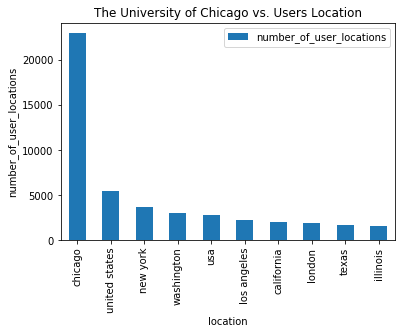

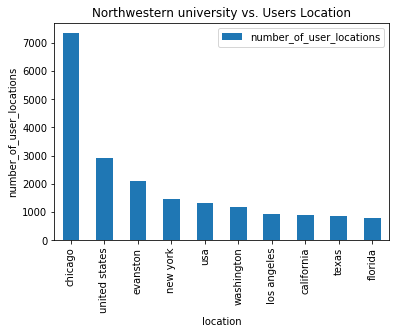

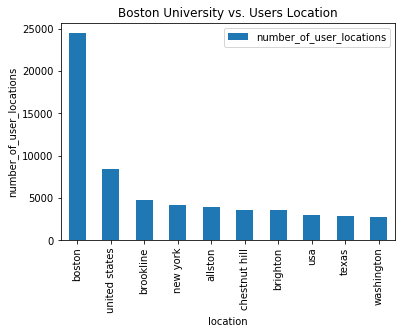

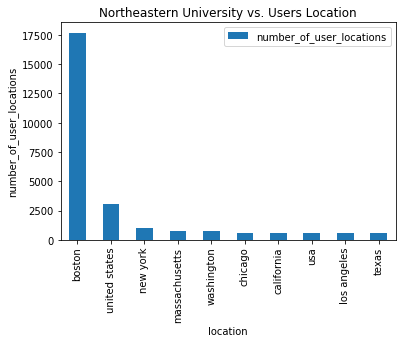

In [33]:
uch_l1.plot(kind = 'bar')
plt.ylabel('number_of_user_locations')
plt.title('The University of Chicago vs. Users Location')
plt.show()

nw_l1.plot(kind = 'bar')
plt.ylabel('number_of_user_locations')
plt.title('Northwestern university vs. Users Location')
plt.show()

bos_l1.plot(kind = 'bar')
plt.ylabel('number_of_user_locations')
plt.title('Boston University vs. Users Location')
plt.show()

neu_l1.plot(kind = 'bar')
plt.ylabel('number_of_user_locations')
plt.title('Northeastern University vs. Users Location')
plt.show()

A large number of twitterers who tweet about the University of Chicago are located in Chicago. A majority of twitterers who tweet about Northwestern University are located in Chicago. For Boston University and Northeastern University, a large number of twitterers are located in Boston. 

### 3). What distinguishes University of Chicago Twitterers vs. Twitterers who tweet about other universities?
Visualize the trends

#### Analyze column rs_retweet_count

In [34]:
uch_rt = uchicago.agg({'rs_retweet_count': 'avg'}).toPandas()
nw_rt = northwestern.agg({'rs_retweet_count': 'avg'}).toPandas()
bos_rt = boston.agg({'rs_retweet_count': 'avg'}).toPandas()
neu_rt = northeastern.agg({'rs_retweet_count': 'avg'}).toPandas()

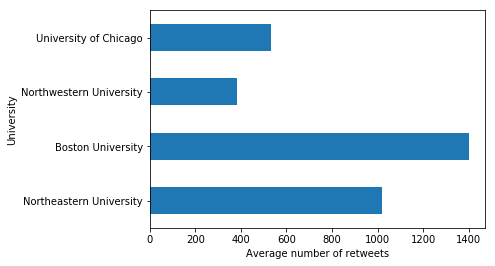

In [35]:
retweets_df = pd.concat([uch_rt, nw_rt, bos_rt, neu_rt], axis = 0)
idx = 0
new_col = ['University of Chicago', 'Northwestern University', 'Boston University', 'Northeastern University']

retweets_df.insert(loc = idx, column = 'University', value = new_col)
retweets_df = retweets_df.set_index('University')
ax = retweets_df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel('Average number of retweets')
ax.get_legend().remove()

#### Analyze column favorite_count, reply_count

In [36]:
print("Avg favorite count - UChicago:")
print(uchicago.agg({'favorite_count': 'avg'}).toPandas())
print("\nAvg favorite count - Northwestern:")
print(northwestern.agg({'favorite_count': 'avg'}).toPandas())
print("\nAvg favorite count - Boston")
print(boston.agg({'favorite_count': 'avg'}).toPandas())
print("\nAvg favorite count - Northeastern")
print(northeastern.agg({'favorite_count': 'avg'}).toPandas())

Avg favorite count - UChicago:
   avg(favorite_count)
0                  0.0

Avg favorite count - Northwestern:
   avg(favorite_count)
0                  0.0

Avg favorite count - Boston
   avg(favorite_count)
0                  0.0

Avg favorite count - Northeastern
   avg(favorite_count)
0                  0.0


In [37]:
print("Avg reply count - UChicago:")
print(uchicago.agg({'reply_count': 'avg'}).toPandas())
print("\nAvg reply count - Northwestern:")
print(northwestern.agg({'reply_count': 'avg'}).toPandas())
print("\nAvg reply count - Boston")
print(boston.agg({'reply_count': 'avg'}).toPandas())
print("\nAvg reply count - Northeastern")
print(northeastern.agg({'reply_count': 'avg'}).toPandas())

Avg reply count - UChicago:
   avg(reply_count)
0               0.0

Avg reply count - Northwestern:
   avg(reply_count)
0               0.0

Avg reply count - Boston
   avg(reply_count)
0               0.0

Avg reply count - Northeastern
   avg(reply_count)
0               0.0


The values are all 0, so it seems that we cannot distinguish University of Chicago twitterers from other universities' twitters by the information of favorite_count, and reply_count.

#### Analyze column user_verified

In [38]:
uch_verified = uchicago.groupBy('user_verified').agg(count("*").alias('number_of_verified_user')).orderBy('number_of_verified_user', ascending = False).limit(2).toPandas()
nw_verified = northwestern.groupBy('user_verified').agg(count("*").alias('number_of_verified_user')).orderBy('number_of_verified_user', ascending = False).limit(2).toPandas()
bos_verified = boston.groupBy('user_verified').agg(count("*").alias('number_of_verified_user')).orderBy('number_of_verified_user', ascending = False).limit(2).toPandas()
neu_verified = northeastern.groupBy('user_verified').agg(count("*").alias('number_of_verified_user')).orderBy('number_of_verified_user', ascending = False).limit(2).toPandas()

In [39]:
from functools import reduce

dfs = [uch_verified, nw_verified, bos_verified, neu_verified]
v_df = reduce(lambda left, right: pd.merge(left, right, on = 'user_verified'), dfs)
v_df.columns = ['user_verified', 'university of chicago', 'northwestern university', 'boston university', 'northeastern university']
v_df = v_df.set_index('user_verified')

v_df1 = v_df.T
v_df1.columns = ['Not verified', 'Verified']
v_df1['Verified_ratio'] = v_df1['Verified']/(v_df1['Not verified']+v_df1['Verified'])

In [40]:
v_df1

,Not verified,Verified,Verified_ratio
university of chicago,292216,7435,0.024812
northwestern university,125374,3716,0.028786
boston university,344361,8366,0.023718
northeastern university,94188,2178,0.022601


Just like Northwestern university's twitterers, University of Chicago's twitterers are more likely to verify their twitter account

#### Analyze column user_followers_count, user_friends_count, user_favourites_count 

In [30]:
# Analyze columns user_follower_count
uch_fl = uchicago.agg({'user_followers_count': 'avg'}).toPandas()
nw_fl = northwestern.agg({'user_followers_count': 'avg'}).toPandas()
bos_fl = boston.agg({'user_followers_count': 'avg'}).toPandas()
neu_fl = northeastern.agg({'user_followers_count': 'avg'}).toPandas()

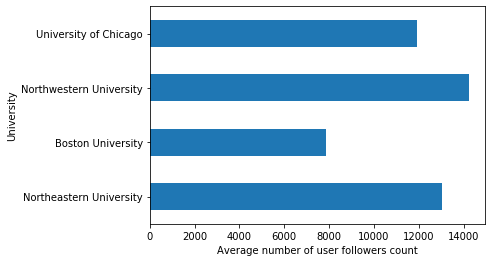

In [31]:
followers_df = pd.concat([uch_fl, nw_fl, bos_fl, neu_fl], axis = 0)
idx = 0
new_col = ['University of Chicago', 'Northwestern University', 'Boston University', 'Northeastern University']

followers_df.insert(loc = idx, column = 'University', value = new_col)
followers_df = followers_df.set_index('University')
ax = followers_df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel('Average number of user followers count')
ax.get_legend().remove()

In [32]:
# Analyze column user_friends_count
uch_fr = uchicago.agg({'user_friends_count': 'avg'}).toPandas()
nw_fr = northwestern.agg({'user_friends_count': 'avg'}).toPandas()
bos_fr = boston.agg({'user_friends_count': 'avg'}).toPandas()
neu_fr = northeastern.agg({'user_friends_count': 'avg'}).toPandas()

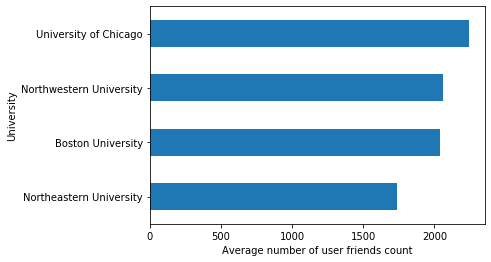

In [33]:
friends_df = pd.concat([uch_fr, nw_fr, bos_fr, neu_fr], axis = 0)

friends_df.insert(loc = idx, column = 'University', value = new_col)
friends_df = friends_df.set_index('University')
ax = friends_df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel('Average number of user friends count')
ax.get_legend().remove()

In [34]:
# Analyze column user_favourites_count
uch_fa = uchicago.agg({'user_favourites_count': 'avg'}).toPandas()
nw_fa = northwestern.agg({'user_favourites_count': 'avg'}).toPandas()
bos_fa = boston.agg({'user_favourites_count': 'avg'}).toPandas()
neu_fa = northeastern.agg({'user_favourites_count': 'avg'}).toPandas()

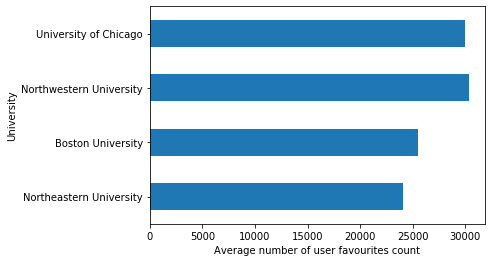

In [35]:
favourites_df = pd.concat([uch_fa, nw_fa, bos_fa, neu_fa], axis = 0)

favourites_df.insert(loc = idx, column = 'University', value = new_col)
favourites_df = favourites_df.set_index('University')
ax = favourites_df.plot.barh()
ax.invert_yaxis()
ax.set_xlabel('Average number of user favourites count')
ax.get_legend().remove()

#### What are top 10 retweeted tweets talking about?

In [ ]:
uch_tp10 = uchicago.select(['text', 'rs_retweet_count']).groupBy('text').agg(sum('rs_retweet_count').alias('retweet_count')).orderBy('retweet_count', ascending = False).limit(10).toPandas()
nw_tp10 = northwestern.select(['text', 'rs_retweet_count']).groupBy('text').agg(sum('rs_retweet_count').alias('retweet_count')).orderBy('retweet_count', ascending = False).limit(10).toPandas()
bos_tp10 = boston.select(['text', 'rs_retweet_count']).groupBy('text').agg(sum('rs_retweet_count').alias('retweet_count')).orderBy('retweet_count', ascending = False).limit(10).toPandas()
neu_tp10 = northeastern.select(['text', 'rs_retweet_count']).groupBy('text').agg(sum('rs_retweet_count').alias('retweet_count')).orderBy('retweet_count', ascending = False).limit(10).toPandas()

In [45]:
uch_tp10['text'].values

array(['RT @ChuckModi1: University of Chicago dropping SAT is huge win against classism. Then THIS!:\n\n“UofC is announcing guarantee of free tuition…',
       'RT @RahulGandhi: My interaction with Prof Dipesh Chakrabarty &amp; students of The University of Chicago, Institute of Politics. https://t.co/5…',
       'RT @TrumpWarRoom: Joe Biden attacked Dr. Scott Atlas, a graduate of the University of Chicago School of Medicine and the former Chief of Ne…',
       'RT @AP: Spoiler alert: 2020 has been rough on the American psyche. A new survey by NORC at the University of Chicago finds Americans are mo…',
       'RT @JoshBreslowWKRN: Dr. Emily Landon with University of Chicago-Medicine speaking on Illinois residents sheltering-in-place: “It’s really…',
       'RT @anthonyocampo: The University of Chicago—whose endowment is $8.5 billion—won’t be paying their resident assistants (RAs) their spring q…',
       'RT @DavidLammy: Evening Mr Rowland. The University of Chicago is indeed a prestig

In [46]:
nw_tp10['text'].values

array(['RT @brithume: The author of this nonsense is a professor at the highly regarded Northwestern University. https://t.co/knf7MJpnNH',
       "RT @charliekirk11: Did you know:\n\nA new audit of Google's search algorithm by Northwestern University researchers confirmed Google's bias a…",
       'RT @travisakers: An 11-year-old rape victim in northwestern university Ohio is pregnant, and a highly restrictive state law on abortion pas…',
       'RT @davidgura: A statement from Northwestern University, on Joseph Epstein: https://t.co/rhCmK2HvSy',
       'RT @lostblackboy: Joseph Epstein’s WSJ op-ed about Dr. Jill Biden embarrassed Northwestern University so much that they issued TWO statemen…',
       "RT @davidgura: A statement from Northwestern University's English Department, about Joseph Epstein: https://t.co/7fsk8KJZB9",
       'RT @BarackObama: In Evanston, IL, Northwestern University faculty and students worked with their police department to develop recommendatio…',
       'RT 

In [47]:
bos_tp10['text'].values

array(['RT @tonyposnanski: AOC graduated Magna Cum Laude from Boston University and won her election in a landslide.\n\nYou barely graduated college,…',
       'RT @DanWetzel: Aaron Hernandez had stage 3 CTE, per attorney Jose Baez. Brain was studied at Boston University. Family will sue NFL and Pat…',
       'RT @rwesthead: Breaking: Boston University researchers say they have developed a method that may help diagnose CTE in living patients.',
       'RT @hemirdesai: BREAKING &amp; SHOCKING NEWS  Finally FBI arrested Professor from Boston University who was in connection with Chinese universi…',
       'RT @TIME: Student who attended Charlottesville white supremacist rally leaves Boston University after backlash… ',
       'RT @johncardillo: Strip you of all that? No. \n\nYou grew up in Westchester County, not the Bronx. \n\nYou went to Boston University, not Bronx…',
       "RT @adamhousley: Microbiologist Robery Davey says they've made a breakthrough last Sunday at Boston University

In [48]:
neu_tp10['text'].values

array(['RT @Northeastern: We want to reassure students who have applied or have been admitted to Northeastern University that disciplinary actions…',
       'RT @BostonGlobe: Northeastern University has dismissed 11 first-year students after they were caught violating social distancing rules, the…',
       'RT @ChuckCallesto: BREAKING REPORT: Northeastern University has dismissed 11 first-year students after they were caught VIOLATING SOCIAL DI…',
       'RT @UberFacts: Humans love dogs more than other humans, according to researchers at Northeastern University and the University of Colorado.',
       'RT @eric_clapp: The buried lede is that Northeastern University didn’t want to miss out on $73,000/year/person (!) by going online, so they…',
       'RT @denial101x: "This just happened" Associate professor Jennifer Bowen at Northeastern University, Boston releases this shocker… ',
       'RT @krassenstein: A new study by researchers from Northeastern University and Harvard University h

### 4). What are the timelines of these tweets? Do you see any significant peaks and valleys?
#### Do you see data collection gaps

In [49]:
data_ts = data.select('created_at').toPandas()

In [50]:
data_ts.shape

(877155, 1)

In [51]:
from datetime import datetime

data_ts['created_at_timestamp'] = np.zeros(shape = (data_ts.shape[0],))
for i in np.arange(data_ts.shape[0]):
    data_ts.loc[i, 'created_at_timestamp'] = datetime.strftime(datetime.strptime(data_ts['created_at'][i],'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S')

In [52]:
data_ts.head()

,created_at,created_at_timestamp
0,Wed Mar 14 20:15:03 +0000 2018,2018-03-14 20:15:03
1,Wed Mar 14 20:15:03 +0000 2018,2018-03-14 20:15:03
2,Wed Mar 14 20:15:03 +0000 2018,2018-03-14 20:15:03
3,Wed Mar 14 20:15:04 +0000 2018,2018-03-14 20:15:04
4,Wed Mar 14 20:15:06 +0000 2018,2018-03-14 20:15:06


In [53]:
data_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877155 entries, 0 to 877154
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   created_at            877155 non-null  object
 1   created_at_timestamp  877155 non-null  object
dtypes: object(2)
memory usage: 13.4+ MB


In [54]:
data_ts['year'] = pd.DatetimeIndex(data_ts['created_at_timestamp']).year
data_ts['month'] = pd.DatetimeIndex(data_ts['created_at_timestamp']).month
data_ts['day'] = pd.DatetimeIndex(data_ts['created_at_timestamp']).day
data_ts['day_of_week'] = pd.DatetimeIndex(data_ts['created_at_timestamp']).dayofweek
data_ts['hour'] = pd.DatetimeIndex(data_ts['created_at_timestamp']).hour

In [73]:
data_ts['year-month-day'] = pd.to_datetime(data_ts[['year', 'month', 'day']])

In [71]:
data_ts.head()

,created_at,created_at_timestamp,year,month,day,day_of_week,hour,year-month-day
0,Wed Mar 14 20:15:03 +0000 2018,2018-03-14 20:15:03,2018,3,14,2,20,2018-03-14
1,Wed Mar 14 20:15:03 +0000 2018,2018-03-14 20:15:03,2018,3,14,2,20,2018-03-14
2,Wed Mar 14 20:15:03 +0000 2018,2018-03-14 20:15:03,2018,3,14,2,20,2018-03-14
3,Wed Mar 14 20:15:04 +0000 2018,2018-03-14 20:15:04,2018,3,14,2,20,2018-03-14
4,Wed Mar 14 20:15:06 +0000 2018,2018-03-14 20:15:06,2018,3,14,2,20,2018-03-14


Text(0.5, 1.0, 'Number of tweets by year')

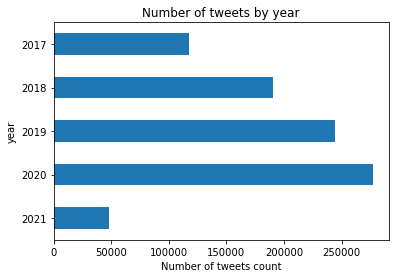

In [81]:
year = data_ts.groupby('year').count()['created_at']
ax = year.plot.barh()
ax.invert_yaxis()
ax.set_xlabel('Number of tweets count')
ax.set_title('Number of tweets by year')

Text(0.5, 1.0, 'Number of tweets by month')

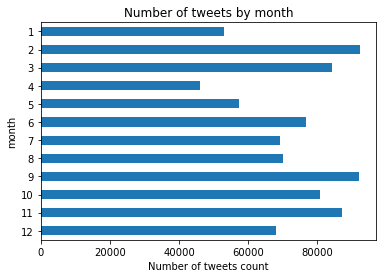

In [80]:
month = data_ts.groupby('month').count()['created_at']
ax = month.plot.barh()
ax.invert_yaxis()
ax.set_xlabel('Number of tweets count')
ax.set_title('Number of tweets by month')

Text(0.5, 1.0, 'Number of tweets by day')

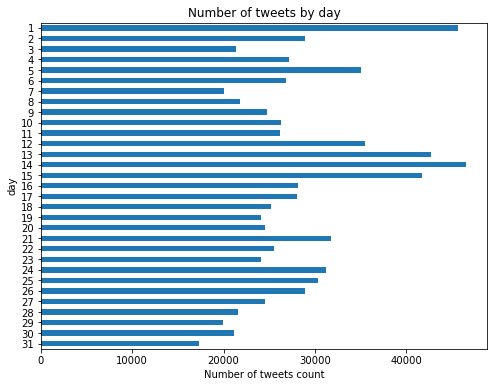

In [79]:
day = data_ts.groupby('day').count()['created_at']
ax = day.plot.barh(figsize = (8,6))
ax.invert_yaxis()
ax.set_xlabel('Number of tweets count')
ax.set_title('Number of tweets by day')

Text(0.5, 1.0, 'Number of tweets by day of week')

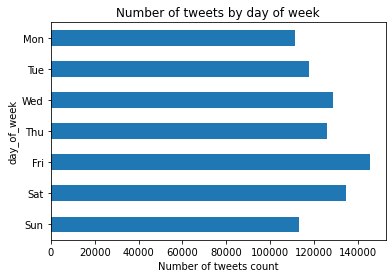

In [78]:
dayofweek = data_ts.groupby('day_of_week').count()['created_at']
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax = dayofweek.plot.barh()
ax.invert_yaxis()
ax.set_yticklabels(labels)
ax.set_xlabel('Number of tweets count')
ax.set_title('Number of tweets by day of week')

Text(0.5, 1.0, 'Number of tweets by hour')

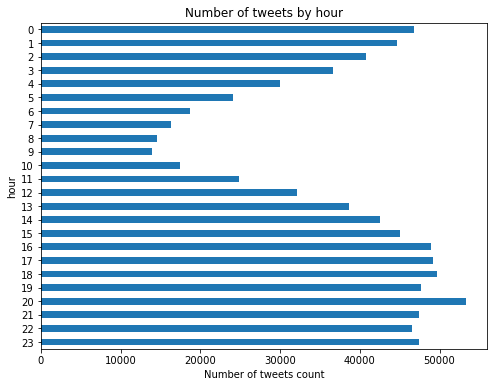

In [77]:
hour = data_ts.groupby('hour').count()['created_at']
ax = hour.plot.barh(figsize = (8,6))
ax.invert_yaxis()
ax.set_xlabel('Number of tweets count')
ax.set_title('Number of tweets by hour')

Text(0.5, 1.0, 'Number of tweets by year-month')

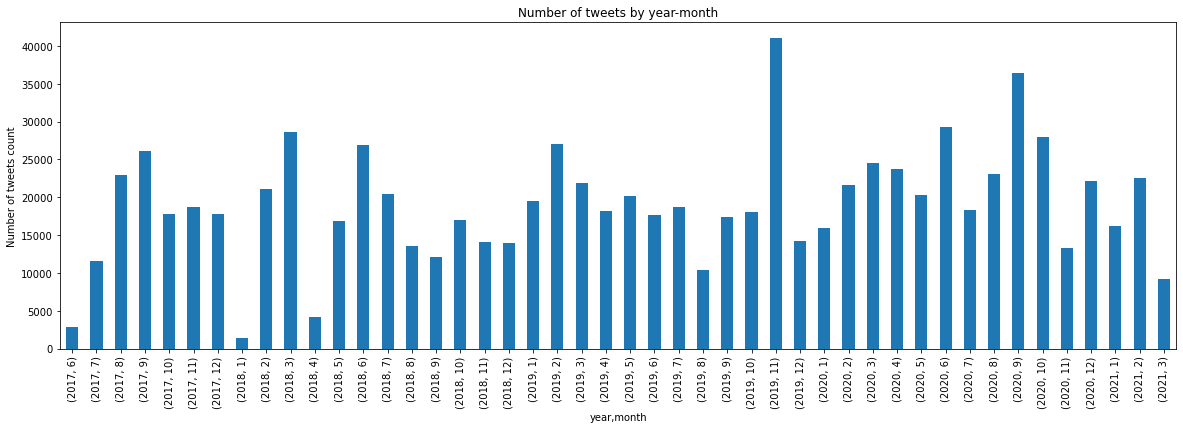

In [76]:
year_month = data_ts.groupby(['year', 'month']).count()['created_at']
ax = year_month.plot.bar(figsize = (20, 6))
ax.set_ylabel('Number of tweets count')
ax.set_title('Number of tweets by year-month')

Text(0.5, 1.0, 'Number of tweets by year-month')

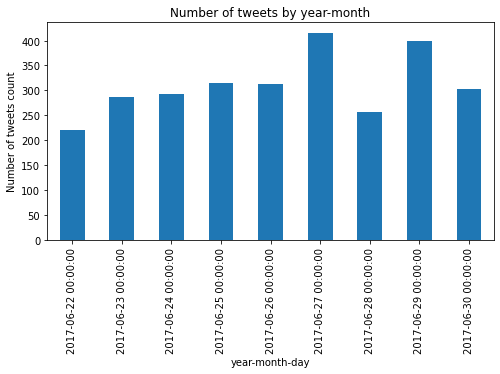

In [89]:
# There are three specific period has tweets fewer than 5000, let's check to see if there is any data collection gap
# June, 2017
df_ts0 = data_ts[(data_ts['year'] == 2017) & (data_ts['month'] == 6)]
ts0 = df_ts0.groupby('year-month-day').count()['created_at']
ax = ts0.plot.bar(figsize = (8, 4))
ax.set_ylabel('Number of tweets count')
ax.set_title('Number of tweets by year-month')

This may be a data collection gap or a fact that the data is collected starting from June,12 2017

Text(0.5, 1.0, 'Number of tweets by year-month')

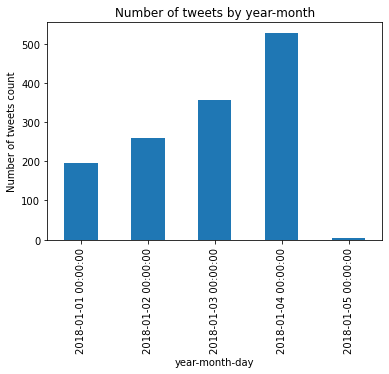

In [91]:
# January, 2018
df_ts1 = data_ts[(data_ts['year'] == 2018) & (data_ts['month'] == 1)]
ts1 = df_ts1.groupby('year-month-day').count()['created_at']
ax = ts1.plot.bar(figsize = (6, 4))
ax.set_ylabel('Number of tweets count')
ax.set_title('Number of tweets by year-month')

There are more than 15,000 tweets collected in December 2017 and February 2018, while fewer than 2000 tweets have been collected in January 2018. We could definitely draw the conclusion that there is a data collection gap in January 2018. The collection gap starts from January, 06 2018 to the end of January, 2018

Text(0.5, 1.0, 'Number of tweets by year-month')

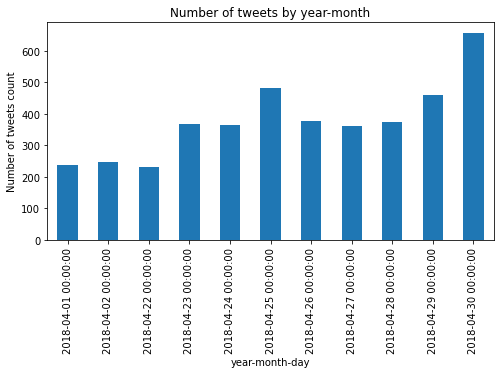

In [93]:
# April, 2018
df_ts2 = data_ts[(data_ts['year'] == 2018) & (data_ts['month'] == 4)]
ts2 = df_ts2.groupby('year-month-day').count()['created_at']
ax = ts2.plot.bar(figsize = (8, 4))
ax.set_ylabel('Number of tweets count')
ax.set_title('Number of tweets by year-month')

There is also a data collection gap in April, 2018. The collection gap starting from April, 3 2018 to April, 21, 2018

### 5). How unique are the messages for each of these universities?
#### Are they mostly unique? Or mostly people are just copy-pasting the same text?

#### Duplicates analysis - University of Chicago

In [34]:
uch_df_text_raw = uchicago.select(['text'])

In [35]:
uch_text = uch_df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

uch_tokens = uch_text\
    .map(lambda document: document.strip().lower())\
    .map(lambda document: re.split(" ", document))\
    .map(lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [36]:
row = Row('text')
uch_df_text = uch_text.map(row).zipWithIndex().toDF(['text','id'])
uch_df_text.limit(5)

text,id
[So the Universit...,275362
[RT @blmohr: 9/ T...,275363
[RT @jadesignlovi...,275364
[RT @blmohr: 9/ T...,275365
[RT @blmohr: 9/ T...,275366


In [37]:
uch_df_tokens = spark.createDataFrame(uch_tokens, ["list_of_words",'id'])

#Drop records with no tokens
uch_df_tokens = uch_df_tokens.where(col('list_of_words').getItem(0).isNotNull())
uch_df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[assistant, dean,, office, of, academic, affai...",0
1,"[rt, @hassankanu:, new:, yale,, columbia,, uni...",1
2,"[rt, @alanfalconx:, glory, carter,, adam, kenn...",2
3,"[rt, @hassankanu:, new:, yale,, columbia,, uni...",3
4,"[rt, @hassankanu:, new:, yale,, columbia,, uni...",4


In [38]:
uch_vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
uch_df_vectorize = uch_vectorize.fit(uch_df_tokens).transform(uch_df_tokens)

In [39]:
uch_df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[assistant, dean,, office, of, academic, affai...",0,"(2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[rt, @hassankanu:, new:, yale,, columbia,, uni...",1,"(1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
2,"[rt, @alanfalconx:, glory, carter,, adam, kenn...",2,"(2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[rt, @hassankanu:, new:, yale,, columbia,, uni...",3,"(1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
4,"[rt, @hassankanu:, new:, yale,, columbia,, uni...",4,"(1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."


In [40]:
uch_mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
uch_model = uch_mh.fit(uch_df_vectorize)
uch_df_hashed = uch_mh.fit(uch_df_vectorize).transform(uch_df_vectorize).cache()

In [41]:
uch_df_hashed_text = uch_df_text.join(uch_df_hashed, "id", how = 'left').cache()
uch_df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
26,"[Check out ""Unive...","[check, out, ""uni...","(189901,[0,4,60,7...","[[4.7945584E7], [..."
29,[RT @DrFrankLipma...,"[rt, @drfranklipm...","(189901,[0,1,2,3,...","[[3.331227E7], [1..."
474,[RT @RahulGandhi:...,"[rt, @rahulgandhi...","(189901,[0,1,2,3,...","[[4.7945584E7], [..."
964,[RT @RahulGandhi:...,"[rt, @rahulgandhi...","(189901,[0,1,2,3,...","[[4.7945584E7], [..."
1677,[RT @RahulGandhi:...,"[rt, @rahulgandhi...","(189901,[0,1,2,3,...","[[4.7945584E7], [..."


In [42]:
jaccard_distance = 0.3

uch_df_dups_text = uch_model.approxSimilarityJoin(uch_df_hashed_text, uch_df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [ ]:
uch_records = uch_df_hashed_text.count()
uch_dups = uch_df_dups_text.select('id_A').distinct().count()
uch_uniques = uch_records - uch_dups

print ('Total records: ', uch_records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', uch_dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uch_uniques)

Total records:  299669
Duplicate titles based on { 0.3 } jaccard distance:  192425
Unique titles based on { 0.3 } jaccard distance:  0.3 :  107244


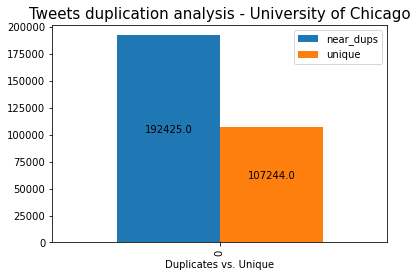

In [ ]:
uch_dups_df = pd.DataFrame.from_dict({'near_dups': [uch_dups], 'unique': [uch_uniques]})

ax = uch_dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8)
ax.set_title('Tweets duplication analysis - University of Chicago', fontsize=15)
ax.set_xlabel("Duplicates vs. Unique")
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### Duplicate analysis - Northwestern University

In [ ]:
nw_df_text_raw = northwestern.select(['text'])

In [ ]:
nw_text = nw_df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

nw_tokens = nw_text\
    .map(lambda document: document.strip().lower())\
    .map(lambda document: re.split(" ", document))\
    .map(lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
row = Row('text')
nw_df_text = nw_text.map(row).zipWithIndex().toDF(['text','id'])
nw_df_text.limit(5)

text,id
[RT @argohs217: C...,128406
[Northwestern Uni...,128407
[New artwork for ...,128408
[@BauhausMovement...,128409
[Northwestern Uni...,128410


In [ ]:
nw_df_tokens = spark.createDataFrame(nw_tokens, ["list_of_words",'id'])

#Drop records with no tokens
nw_df_tokens = nw_df_tokens.where(col('list_of_words').getItem(0).isNotNull())
nw_df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[rt, @evan_rosenfeld:, breaking:, northwestern...",0
1,"[rt, @dianexlston:, also, feel, like?, we, pro...",1
2,"[rt, @chicagotribune:, breaking:, police, resp...",2
3,"[rt, @tpm:, northwestern, university, reports,...",3
4,"[breaking:, northwestern, university, confirms...",4


In [ ]:
nw_vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
nw_df_vectorize = nw_vectorize.fit(nw_df_tokens).transform(nw_df_tokens)

In [ ]:
nw_df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[rt, @evan_rosenfeld:, breaking:, northwestern...",0,"(1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[rt, @dianexlston:, also, feel, like?, we, pro...",1,"(1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2,"[rt, @chicagotribune:, breaking:, police, resp...",2,"(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, ..."
3,"[rt, @tpm:, northwestern, university, reports,...",3,"(1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[breaking:, northwestern, university, confirms...",4,"(1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
nw_mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
nw_model = nw_mh.fit(nw_df_vectorize)
nw_df_hashed = nw_mh.fit(nw_df_vectorize).transform(nw_df_vectorize).cache()

In [ ]:
nw_df_hashed_text = nw_df_text.join(nw_df_hashed, "id", how = 'left').cache()
nw_df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
112,[RT @AlBoeNEWS: #...,"[rt, @alboenews:,...","(97972,[0,1,2,6,7...","[[4.7945584E7], [..."
113,[RT @KTLA: There'...,"[rt, @ktla:, ther...","(97972,[0,1,2,3,5...","[[515903.0], [1.4..."
155,[#DEVELOPING: Eme...,"[#developing:, em...","(97972,[0,11,15,3...","[[4.7945584E7], [..."
167,[RT @AlBoeNEWS: #...,"[rt, @alboenews:,...","(97972,[0,1,6,7,1...","[[4.7945584E7], [..."
299,[RT @NPR: Northwe...,"[rt, @npr:, north...","(97972,[0,1,3,4,7...","[[4.7945584E7], [..."


In [ ]:
jaccard_distance = 0.3

nw_df_dups_text = nw_model.approxSimilarityJoin(nw_df_hashed_text, nw_df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [ ]:
nw_df_dups_text.cache()
nw_df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,93942,101415,(RT @blakewes8: Blessed to receive a D1 offer ...,(RT @blakewes8: Blessed to receive a D1 offer ...
1,0.0,18263,32839,(RT @LaCharles88: The new dean of Northwestern...,(RT @LaCharles88: The new dean of Northwestern...
2,0.0,17860,18262,(RT @LaCharles88: The new dean of Northwestern...,(RT @LaCharles88: The new dean of Northwestern...
3,0.0,17860,23232,(RT @LaCharles88: The new dean of Northwestern...,(RT @LaCharles88: The new dean of Northwestern...
4,0.0,11826,18263,(RT @LaCharles88: The new dean of Northwestern...,(RT @LaCharles88: The new dean of Northwestern...


In [ ]:
nw_records = nw_df_hashed_text.count()
nw_dups = nw_df_dups_text.select('id_A').distinct().count()
nw_uniques = nw_records - nw_dups

print ('Total records: ', nw_records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', nw_dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', nw_uniques)

Total records:  129098
Duplicate titles based on { 0.3 } jaccard distance:  86833
Unique titles based on { 0.3 } jaccard distance:  0.3 :  42265


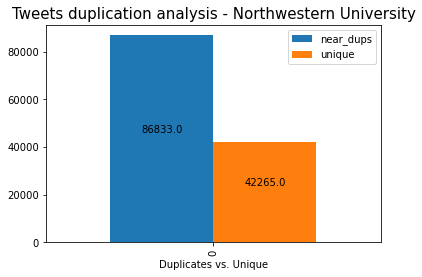

In [ ]:
nw_dups_df = pd.DataFrame.from_dict({'near_dups': [nw_dups], 'unique': [nw_uniques]})

ax = nw_dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8)
ax.set_title('Tweets duplication analysis - Northwestern University', fontsize=15)
ax.set_xlabel("Duplicates vs. Unique")
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### Duplicate Analysis - Boston University

In [18]:
bos_df_text_raw = boston.select(['text'])

In [19]:
bos_text = bos_df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

bos_tokens = bos_text\
    .map(lambda document: document.strip().lower())\
    .map(lambda document: re.split(" ", document))\
    .map(lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
row = Row('text')
bos_df_text = bos_text.map(row).zipWithIndex().toDF(['text','id'])
bos_df_text.limit(5)

text,id
[RT @umichwsoccer...,299195
[RT @umichwsoccer...,299196
[RT @umichwsoccer...,299197
[RT @umichwsoccer...,299198
[RT @duxfeminafac...,299199


In [ ]:
bos_df_tokens = spark.createDataFrame(bos_tokens, ["list_of_words",'id'])

#Drop records with no tokens
bos_df_tokens = bos_df_tokens.where(col('list_of_words').getItem(0).isNotNull())
bos_df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[rt, @stagswomenslax:, gameday, vs., boston, u...",0
1,"[rt, @knopovanita:, boston, university, medica...",1
2,"[rt, @knopovanita:, boston, university, medica...",2
3,"[rt, @tatianamoylan:, #nationalwalkout, day, a...",3
4,"[rt, @tatianamoylan:, #nationalwalkout, day, a...",4


In [ ]:
bos_vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
bos_df_vectorize = bos_vectorize.fit(bos_df_tokens).transform(bos_df_tokens)

In [ ]:
bos_df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[rt, @stagswomenslax:, gameday, vs., boston, u...",0,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[rt, @knopovanita:, boston, university, medica...",1,"(1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[rt, @knopovanita:, boston, university, medica...",2,"(1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[rt, @tatianamoylan:, #nationalwalkout, day, a...",3,"(1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,"[rt, @tatianamoylan:, #nationalwalkout, day, a...",4,"(1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


In [ ]:
bos_mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
bos_model = bos_mh.fit(bos_df_vectorize)
bos_df_hashed = bos_mh.fit(bos_df_vectorize).transform(bos_df_vectorize).cache()

In [ ]:
bos_df_hashed_text = bos_df_text.join(bos_df_hashed, "id", how = 'left').cache()
bos_df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
19,[RT @lindseyadler...,"[rt, @lindseyadle...","(233668,[0,1,2,3,...","[[4.7945584E7], [..."
54,[RT @DanWetzel: A...,"[rt, @danwetzel:,...","(233668,[0,2,6,10...","[[4.7945584E7], [..."
296,[RT @DanWetzel: A...,"[rt, @danwetzel:,...","(233668,[0,2,6,10...","[[4.7945584E7], [..."
926,[RT @DanWetzel: A...,"[rt, @danwetzel:,...","(233668,[0,2,6,10...","[[4.7945584E7], [..."
965,[RT @rwesthead: B...,"[rt, @rwesthead:,...","(233668,[0,1,2,7,...","[[4.7945584E7], [..."


In [ ]:
jaccard_distance = 0.3

bos_df_dups_text = bos_model.approxSimilarityJoin(bos_df_hashed_text, bos_df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [ ]:
bos_records = bos_df_hashed_text.count()
bos_dups = bos_df_dups_text.select('id_A').distinct().count()
bos_uniques = bos_records - bos_dups

print ('Total records: ', bos_records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', bos_dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', bos_uniques)

Total records:  352767
Duplicate titles based on { 0.3 } jaccard distance:  207799
Unique titles based on { 0.3 } jaccard distance:  0.3 :  144968


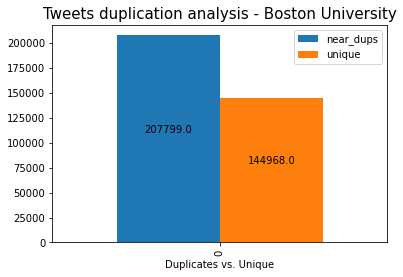

In [ ]:
bos_dups_df = pd.DataFrame.from_dict({'near_dups': [bos_dups], 'unique': [bos_uniques]})

ax = bos_dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8)
ax.set_title('Tweets duplication analysis - Boston University', fontsize=15)
ax.set_xlabel("Duplicates vs. Unique")
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### Duplicate Analysis - Northeastern University

In [ ]:
neu_df_text_raw = northeastern.select(['text'])

In [ ]:
neu_text = neu_df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

neu_tokens = neu_text\
    .map(lambda document: document.strip().lower())\
    .map(lambda document: re.split(" ", document))\
    .map(lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
row = Row('text')
neu_df_text = neu_text.map(row).zipWithIndex().toDF(['text','id'])
neu_df_text.limit(5)

text,id
[Did you know? 73...,38845
[Congratulations ...,38846
[Northeastern Uni...,38847
[Northeastern Uni...,38848
[RT @BHSWarhawks:...,38849


In [ ]:
neu_df_tokens = spark.createDataFrame(neu_tokens, ["list_of_words",'id'])

#Drop records with no tokens
neu_df_tokens = neu_df_tokens.where(col('list_of_words').getItem(0).isNotNull())
neu_df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[please, join, us, for, our, part, webinar, se...",0
1,"[join, us, for, our, webinar, series, on, nort...",1
2,"[several, student, organizations, at, the, nor...",2
3,"[find, yourself, parking, lot, that, gives, yo...",3
4,"[please, join, us, for, our, part, webinar, se...",4


In [ ]:
neu_vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
neu_df_vectorize = neu_vectorize.fit(neu_df_tokens).transform(neu_df_tokens)

In [ ]:
neu_df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[please, join, us, for, our, part, webinar, se...",0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[join, us, for, our, webinar, series, on, nort...",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[several, student, organizations, at, the, nor...",2,"(1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ..."
3,"[find, yourself, parking, lot, that, gives, yo...",3,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[please, join, us, for, our, part, webinar, se...",4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
neu_mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
neu_model = neu_mh.fit(neu_df_vectorize)
neu_df_hashed = neu_mh.fit(neu_df_vectorize).transform(neu_df_vectorize).cache()

In [ ]:
neu_df_hashed_text = neu_df_text.join(neu_df_hashed, "id", how = 'left').cache()
neu_df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
243,[RT @BostonGlobe:...,"[rt, @bostonglobe...","(71544,[0,1,2,7,1...","[[3.331227E7], [1..."
278,[RT @ChuckCallest...,"[rt, @chuckcalles...","(71544,[0,1,2,7,1...","[[3.331227E7], [1..."
367,[RT @ChuckCallest...,"[rt, @chuckcalles...","(71544,[0,1,2,7,1...","[[3.331227E7], [1..."
442,[RT @ChuckCallest...,"[rt, @chuckcalles...","(71544,[0,1,2,7,1...","[[3.331227E7], [1..."
705,[RT @ChuckCallest...,"[rt, @chuckcalles...","(71544,[0,1,2,7,1...","[[3.331227E7], [1..."


In [ ]:
jaccard_distance = 0.3

neu_df_dups_text = neu_model.approxSimilarityJoin(neu_df_hashed_text, neu_df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [ ]:
neu_records = neu_df_hashed_text.count()
neu_dups = neu_df_dups_text.select('id_A').distinct().count()
neu_uniques = neu_records - neu_dups

print ('Total records: ', neu_records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', neu_dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', neu_uniques)

Total records:  96374
Duplicate titles based on { 0.3 } jaccard distance:  76792
Unique titles based on { 0.3 } jaccard distance:  0.3 :  19582


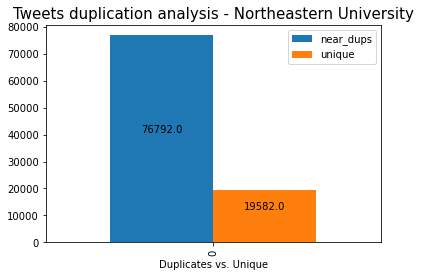

In [ ]:
neu_dups_df = pd.DataFrame.from_dict({'near_dups': [neu_dups], 'unique': [neu_uniques]})

ax = neu_dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8)
ax.set_title('Tweets duplication analysis - Northeastern University', fontsize=15)
ax.set_xlabel("Duplicates vs. Unique")
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 